# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


[link text](https://)# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [2]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        # dummy assignment until this function is filled in
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)


    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
      h1 = F.relu(self.fc1(x))
      # return self.fc21(h1)

      # return self.fc21(h1)
      # return self.fc22(h2)

      # return self.fc22(h1)
      # return self.fc21(h21)

      # h22 = self.fc22(h2)
      # return self.fc22(h22)

      # dummy assignment until this function is filled in
      means = self.fc21(h1)
      log_variances = self.fc22(h1)
      return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):

        # dummy assignment until this function is filled in
        std = torch.exp(0.5*log_variances)
        eps = torch.randn_like(std)
        embedding = means + (eps*std)
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
      h2 = F.relu(self.fc3(z))
      #######################################################################################
      # return torch.sigmoid(self.fc4(h4))
    

      # dummy assignment until this function is filled in
      probabilties = torch.sigmoid(self.fc4(h2))
      return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):
        # dummy assignment until this function is filled in
        # probabilties = torch.sigmoid(self.fc4(x))
        means, log_variances = self.encode(x.view(-1, 784))
        z = self.reparameterize(means,log_variances)
        return self.decode(z), means, log_variances

# Loss Functions

# Training

In [3]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    train_BCE = 0
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        total_loss , BCE_loss = vae_loss_function(recon_batch, data, means, log_variances)
        total_loss.backward()
        train_BCE += BCE_loss.item()
        train_loss += total_loss.item() 
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                total_loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    average_train_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average total loss: {:.4f}'.format(
          epoch, average_train_loss))
   
    return average_train_loss, average_train_BCE



# Testing

In [4]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
    model.eval()
    test_BCE = 0
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            total_loss , BCE_loss = vae_loss_function(recon_batch, data, means, log_variances)
            test_BCE += BCE_loss.item()
            test_loss += total_loss.item() 
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                        'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
  
    average_test_loss = test_loss / len(train_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_loss))
    
    return average_test_loss, average_test_BCE


# Main

In [5]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114

# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20

# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)

def vae_loss_function(reconstructed_x, x, means, log_variances):

    # dummy assignment until this function is filled in
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KL_divergence_loss = -0.5 * torch.sum(1 + log_variances - torch.pow(means,2) - torch.exp(log_variances))
    total_loss = BCE + KL_divergence_loss
    return total_loss, BCE


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.855591
Train Epoch: 1 [12800/60000 (21%)]	Loss: 148.973511
Train Epoch: 1 [25600/60000 (43%)]	Loss: 119.081879
Train Epoch: 1 [38400/60000 (64%)]	Loss: 99.843643
Train Epoch: 1 [51200/60000 (85%)]	Loss: 95.915977
====> Epoch: 1 Average loss: 130.6156
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


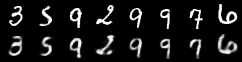

====> Test set loss: 87.3666
Sample of generated images


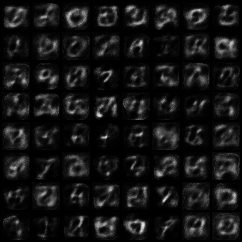



Train Epoch: 2 [0/60000 (0%)]	Loss: 87.483559
Train Epoch: 2 [12800/60000 (21%)]	Loss: 80.420944
Train Epoch: 2 [25600/60000 (43%)]	Loss: 78.942719
Train Epoch: 2 [38400/60000 (64%)]	Loss: 80.700333
Train Epoch: 2 [51200/60000 (85%)]	Loss: 77.762634
====> Epoch: 2 Average loss: 82.2250
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


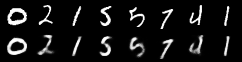

====> Test set loss: 77.6817
Sample of generated images


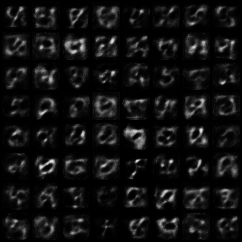



Train Epoch: 3 [0/60000 (0%)]	Loss: 77.134583
Train Epoch: 3 [12800/60000 (21%)]	Loss: 78.660812
Train Epoch: 3 [25600/60000 (43%)]	Loss: 74.584702
Train Epoch: 3 [38400/60000 (64%)]	Loss: 76.517143
Train Epoch: 3 [51200/60000 (85%)]	Loss: 76.861420
====> Epoch: 3 Average loss: 76.6155
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


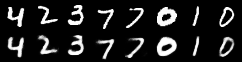

====> Test set loss: 74.3645
Sample of generated images


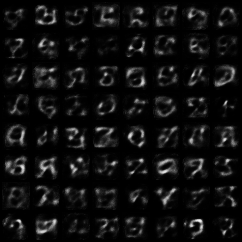



Train Epoch: 4 [0/60000 (0%)]	Loss: 73.868752
Train Epoch: 4 [12800/60000 (21%)]	Loss: 72.926018
Train Epoch: 4 [25600/60000 (43%)]	Loss: 74.802383
Train Epoch: 4 [38400/60000 (64%)]	Loss: 75.383118
Train Epoch: 4 [51200/60000 (85%)]	Loss: 74.786102
====> Epoch: 4 Average loss: 73.9689
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


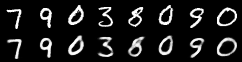

====> Test set loss: 72.4586
Sample of generated images


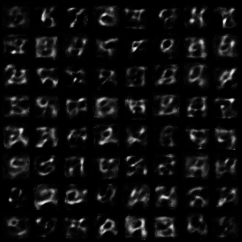



Train Epoch: 5 [0/60000 (0%)]	Loss: 71.572556
Train Epoch: 5 [12800/60000 (21%)]	Loss: 73.094070
Train Epoch: 5 [25600/60000 (43%)]	Loss: 71.501831
Train Epoch: 5 [38400/60000 (64%)]	Loss: 71.625015
Train Epoch: 5 [51200/60000 (85%)]	Loss: 74.515015
====> Epoch: 5 Average loss: 72.2628
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


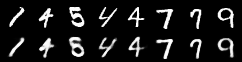

====> Test set loss: 71.0572
Sample of generated images


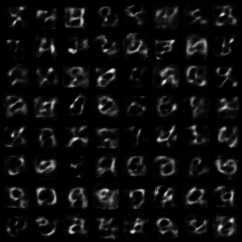



Train Epoch: 6 [0/60000 (0%)]	Loss: 70.784210
Train Epoch: 6 [12800/60000 (21%)]	Loss: 75.017326
Train Epoch: 6 [25600/60000 (43%)]	Loss: 73.107681
Train Epoch: 6 [38400/60000 (64%)]	Loss: 69.995514
====> Epoch: 6 Average loss: 71.0011
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


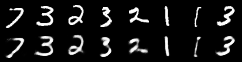

====> Test set loss: 70.1989
Sample of generated images


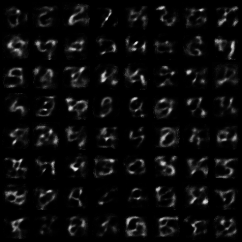



Train Epoch: 7 [0/60000 (0%)]	Loss: 71.245239
Train Epoch: 7 [12800/60000 (21%)]	Loss: 70.001740
Train Epoch: 7 [25600/60000 (43%)]	Loss: 66.885101
Train Epoch: 7 [38400/60000 (64%)]	Loss: 69.423630
Train Epoch: 7 [51200/60000 (85%)]	Loss: 71.551132
====> Epoch: 7 Average loss: 70.0553
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


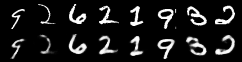

====> Test set loss: 69.4386
Sample of generated images


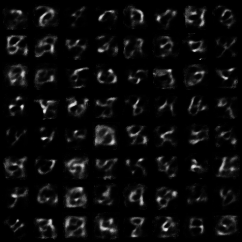



Train Epoch: 8 [0/60000 (0%)]	Loss: 74.021530
Train Epoch: 8 [12800/60000 (21%)]	Loss: 72.654037
Train Epoch: 8 [25600/60000 (43%)]	Loss: 69.241867
Train Epoch: 8 [38400/60000 (64%)]	Loss: 69.053482
Train Epoch: 8 [51200/60000 (85%)]	Loss: 70.606438
====> Epoch: 8 Average loss: 69.2943
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


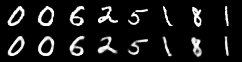

====> Test set loss: 68.9353
Sample of generated images


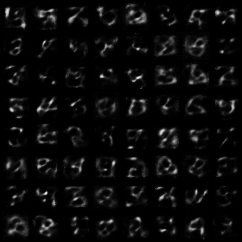



Train Epoch: 9 [0/60000 (0%)]	Loss: 70.341080
Train Epoch: 9 [12800/60000 (21%)]	Loss: 67.984085
Train Epoch: 9 [25600/60000 (43%)]	Loss: 68.979935
Train Epoch: 9 [38400/60000 (64%)]	Loss: 69.972237
Train Epoch: 9 [51200/60000 (85%)]	Loss: 74.313179
====> Epoch: 9 Average loss: 68.7033
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


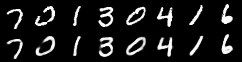

====> Test set loss: 68.3110
Sample of generated images


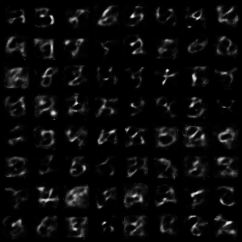



Train Epoch: 10 [0/60000 (0%)]	Loss: 67.687988
Train Epoch: 10 [12800/60000 (21%)]	Loss: 66.762878
Train Epoch: 10 [25600/60000 (43%)]	Loss: 69.184677
Train Epoch: 10 [38400/60000 (64%)]	Loss: 67.615829
Train Epoch: 10 [51200/60000 (85%)]	Loss: 69.718491
====> Epoch: 10 Average loss: 68.1669
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


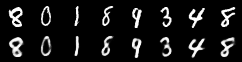

====> Test set loss: 67.9646
Sample of generated images


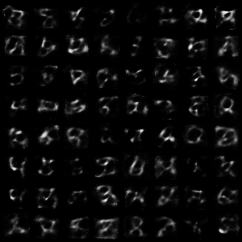



Train Epoch: 1 [0/60000 (0%)]	Loss: 549.285339
Train Epoch: 1 [12800/60000 (21%)]	Loss: 184.463501
Train Epoch: 1 [25600/60000 (43%)]	Loss: 159.581650
Train Epoch: 1 [38400/60000 (64%)]	Loss: 148.722733
Train Epoch: 1 [51200/60000 (85%)]	Loss: 137.594055
====> Epoch: 1 Average loss: 151.1175
====> Epoch: 1 Average total loss: 166.0727
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


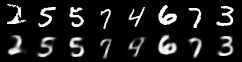

====> Test set loss: 108.1798
====> Test set loss: 21.4141
Sample of generated images


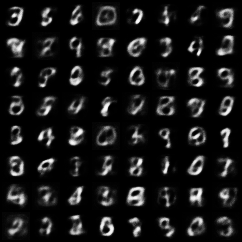



Train Epoch: 2 [0/60000 (0%)]	Loss: 133.428207
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.877090
Train Epoch: 2 [25600/60000 (43%)]	Loss: 123.908348
Train Epoch: 2 [38400/60000 (64%)]	Loss: 119.524757
Train Epoch: 2 [51200/60000 (85%)]	Loss: 114.852112
====> Epoch: 2 Average loss: 99.9612
====> Epoch: 2 Average total loss: 122.1441
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


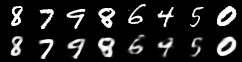

====> Test set loss: 92.0195
====> Test set loss: 19.3534
Sample of generated images


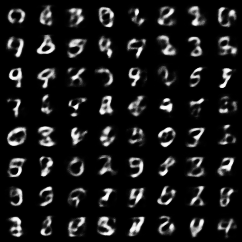



Train Epoch: 3 [0/60000 (0%)]	Loss: 114.243729
Train Epoch: 3 [12800/60000 (21%)]	Loss: 120.448624
Train Epoch: 3 [25600/60000 (43%)]	Loss: 117.557449
Train Epoch: 3 [38400/60000 (64%)]	Loss: 120.167015
Train Epoch: 3 [51200/60000 (85%)]	Loss: 112.768234
====> Epoch: 3 Average loss: 91.1384
====> Epoch: 3 Average total loss: 115.0001
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


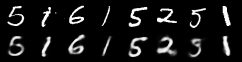

====> Test set loss: 87.6568
====> Test set loss: 18.6955
Sample of generated images


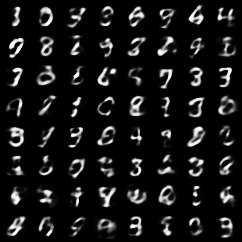



Train Epoch: 4 [0/60000 (0%)]	Loss: 111.567413
Train Epoch: 4 [12800/60000 (21%)]	Loss: 109.209396
Train Epoch: 4 [25600/60000 (43%)]	Loss: 112.496490
Train Epoch: 4 [38400/60000 (64%)]	Loss: 115.341499
Train Epoch: 4 [51200/60000 (85%)]	Loss: 111.143837
====> Epoch: 4 Average loss: 87.5407
====> Epoch: 4 Average total loss: 111.9964
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


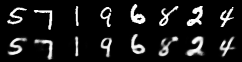

====> Test set loss: 84.9421
====> Test set loss: 18.3718
Sample of generated images


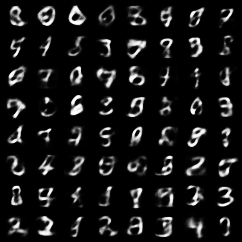



Train Epoch: 5 [0/60000 (0%)]	Loss: 112.691742
Train Epoch: 5 [12800/60000 (21%)]	Loss: 111.704575
Train Epoch: 5 [25600/60000 (43%)]	Loss: 111.946571
Train Epoch: 5 [38400/60000 (64%)]	Loss: 111.889465
Train Epoch: 5 [51200/60000 (85%)]	Loss: 105.522636
====> Epoch: 5 Average loss: 85.4735
====> Epoch: 5 Average total loss: 110.1916
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


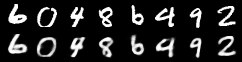

====> Test set loss: 83.7564
====> Test set loss: 18.1482
Sample of generated images


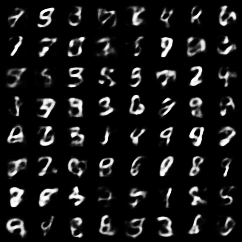



Train Epoch: 6 [0/60000 (0%)]	Loss: 110.459091
Train Epoch: 6 [12800/60000 (21%)]	Loss: 109.990067
Train Epoch: 6 [25600/60000 (43%)]	Loss: 106.180954
Train Epoch: 6 [38400/60000 (64%)]	Loss: 110.965256
Train Epoch: 6 [51200/60000 (85%)]	Loss: 106.596497
====> Epoch: 6 Average loss: 84.1105
====> Epoch: 6 Average total loss: 109.0336
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


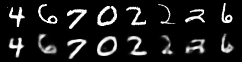

====> Test set loss: 83.4710
====> Test set loss: 17.9584
Sample of generated images


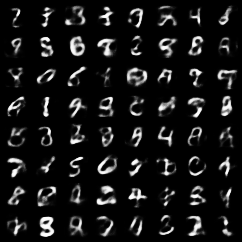



Train Epoch: 7 [0/60000 (0%)]	Loss: 104.967720
Train Epoch: 7 [12800/60000 (21%)]	Loss: 104.860214
Train Epoch: 7 [25600/60000 (43%)]	Loss: 111.238922
Train Epoch: 7 [38400/60000 (64%)]	Loss: 109.628410
Train Epoch: 7 [51200/60000 (85%)]	Loss: 103.491028
====> Epoch: 7 Average loss: 83.1003
====> Epoch: 7 Average total loss: 108.1679
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


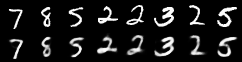

====> Test set loss: 81.9154
====> Test set loss: 17.8611
Sample of generated images


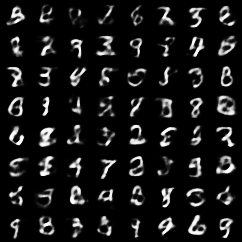



Train Epoch: 8 [0/60000 (0%)]	Loss: 105.754578
Train Epoch: 8 [12800/60000 (21%)]	Loss: 105.631958
Train Epoch: 8 [25600/60000 (43%)]	Loss: 106.452637
Train Epoch: 8 [38400/60000 (64%)]	Loss: 110.744980
Train Epoch: 8 [51200/60000 (85%)]	Loss: 107.600227
====> Epoch: 8 Average loss: 82.3049
====> Epoch: 8 Average total loss: 107.4225
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


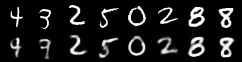

====> Test set loss: 81.5596
====> Test set loss: 17.7917
Sample of generated images


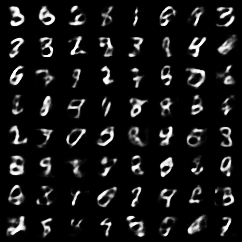



Train Epoch: 9 [0/60000 (0%)]	Loss: 106.207382
Train Epoch: 9 [12800/60000 (21%)]	Loss: 106.736900
Train Epoch: 9 [25600/60000 (43%)]	Loss: 107.283295
Train Epoch: 9 [38400/60000 (64%)]	Loss: 104.042259
Train Epoch: 9 [51200/60000 (85%)]	Loss: 109.735657
====> Epoch: 9 Average loss: 81.7666
====> Epoch: 9 Average total loss: 107.0058
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


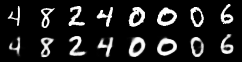

====> Test set loss: 80.9756
====> Test set loss: 17.6894
Sample of generated images


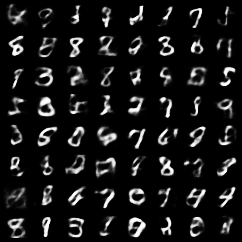



Train Epoch: 10 [0/60000 (0%)]	Loss: 103.614914
Train Epoch: 10 [12800/60000 (21%)]	Loss: 106.418205
Train Epoch: 10 [25600/60000 (43%)]	Loss: 105.191711
Train Epoch: 10 [38400/60000 (64%)]	Loss: 108.076698
Train Epoch: 10 [51200/60000 (85%)]	Loss: 104.174118
====> Epoch: 10 Average loss: 81.2463
====> Epoch: 10 Average total loss: 106.4920
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


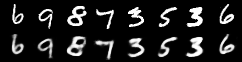

====> Test set loss: 80.2130
====> Test set loss: 17.6670
Sample of generated images


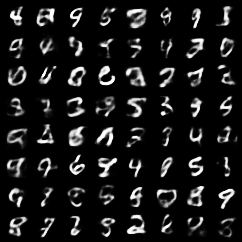

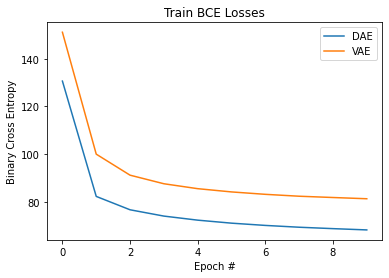

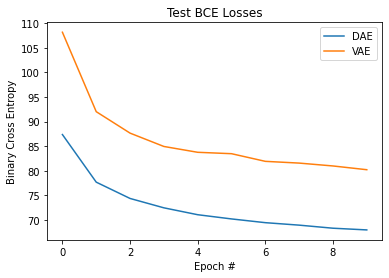

In [6]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                  'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()